In [79]:
import tensorflow as tf
from tensorflow.keras import layers,models
from matplotlib import pyplot as plt
import numpy as np
import os

In [80]:
img_size=256
bth_size=32
ip_shape=(bth_size,img_size,img_size,3)
n_cls=10
EPOCHS=50

In [81]:
tf_data=tf.keras.preprocessing.image_dataset_from_directory('PlantVillage',image_size=(img_size,img_size),shuffle=True,batch_size=bth_size)

Found 16011 files belonging to 10 classes.


In [82]:
cls_name = tf_data.class_names
cls_name

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [83]:
len(tf_data)

501

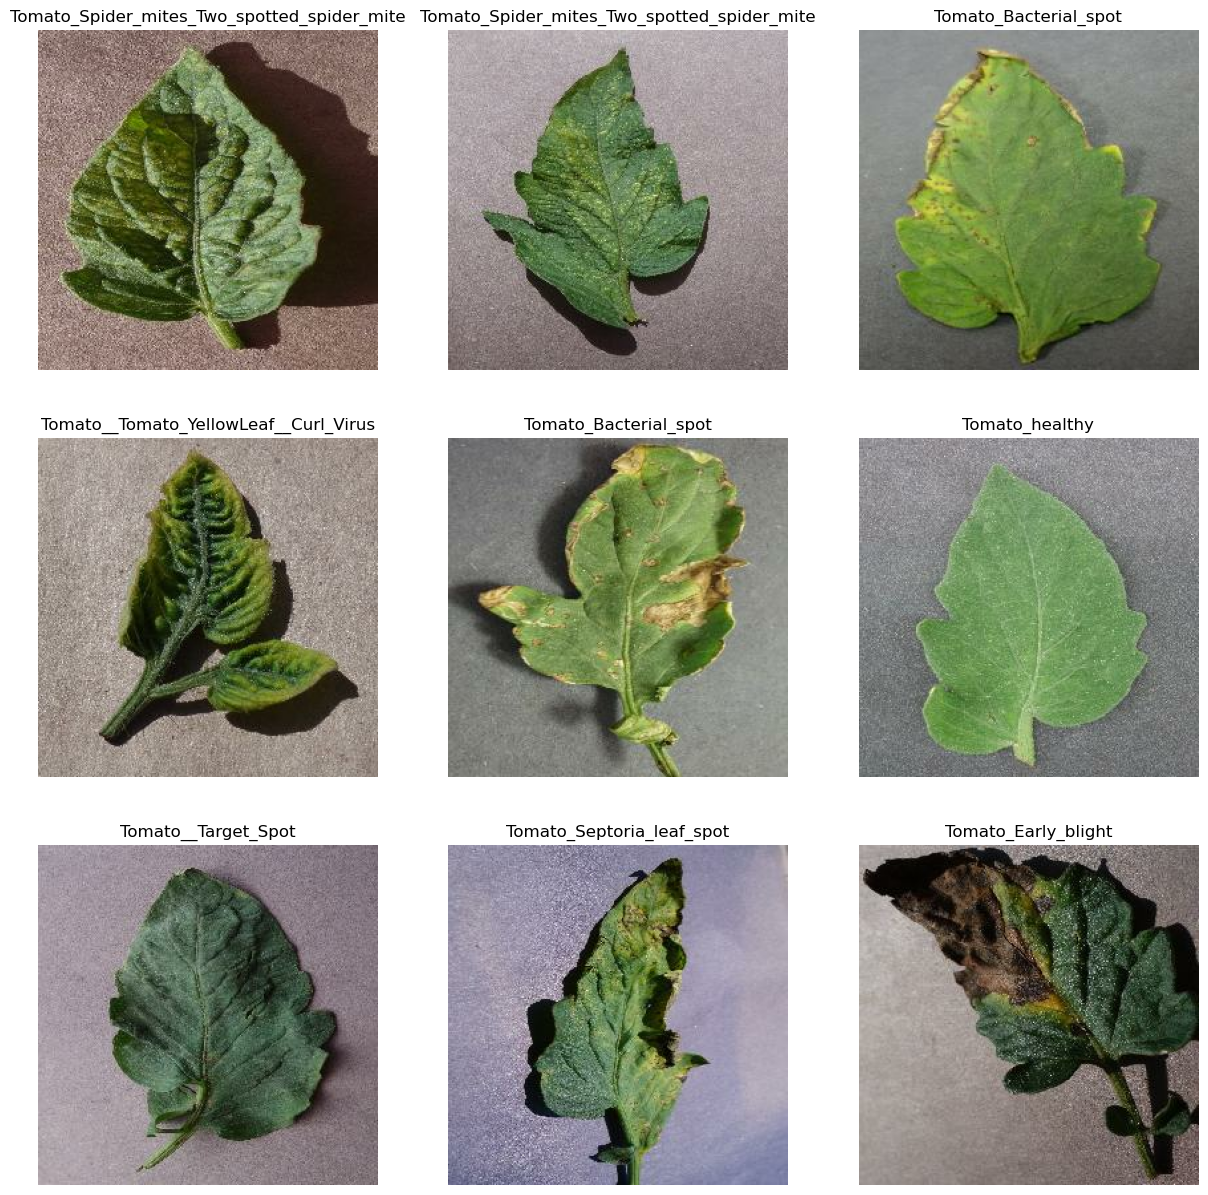

In [84]:
plt.figure(figsize=(15,15))
for img_batch,label_batch in tf_data.take(1):
    for i in range(9):
       
        plt.subplot(3,3,i+1)
        plt.imshow(img_batch[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(cls_name[label_batch[i]])

In [85]:
data_size = len(tf_data)
train_size=round(data_size*0.8)
test_size=data_size-train_size
valid_size=test_size//2
test_size=valid_size

## Train 80%
## Test 20%
#### ->Validation 10%
#### ->Test 10%

In [86]:
train_size,test_size,valid_size

(401, 50, 50)

In [87]:
train_ds=tf_data.take(train_size)

In [88]:
test_ds = tf_data.skip(train_size)

In [89]:
valid_ds = test_ds.take(valid_size)

In [90]:
test_ds=test_ds.skip(valid_size)

In [91]:
def get_data_partition(tf_data,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    data_size=len(tf_data)
    train_size=round(data_size*train_split)
    val_size=round(data_size*val_split)
    if shuffle:
        tf_data=tf_data.shuffle(shuffle_size,seed=12)
    train_ds=tf_data.take(train_size)
    valid_ds=tf_data.skip(train_size).take(val_size)
    test_ds=tf_data.skip( train_size).skip(val_size)
    return train_ds,valid_ds,test_ds

In [92]:
train_ds,valid_ds,test_ds=get_data_partition(tf_data)
len(train_ds),len(valid_ds),len(test_ds)

(401, 50, 50)

In [93]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds=valid_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [94]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(img_size,img_size),
    layers.experimental.preprocessing.Rescaling(1.0/img_size),
])

In [95]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [96]:
model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=ip_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_cls, activation='softmax'),
])
model.build(input_shape=ip_shape)

In [97]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 conv2d_24 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_24 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (32, 60, 60, 64)        

In [98]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])


In [99]:
history= model.fit(train_ds,
         epochs=EPOCHS,
         batch_size=bth_size,
         verbose=1,
         validation_data=valid_ds)

Epoch 1/50
401/401 [==============================] - 409s 907ms/step - loss: 1.4889 - accuracy: 0.4736 - val_loss: 0.9708 - val_accuracy: 0.6587
Epoch 2/50
401/401 [==============================] - 244s 608ms/step - loss: 0.7262 - accuracy: 0.7511 - val_loss: 0.4782 - val_accuracy: 0.8325
Epoch 3/50
401/401 [==============================] - 242s 603ms/step - loss: 0.4591 - accuracy: 0.8434 - val_loss: 0.4000 - val_accuracy: 0.8644
Epoch 4/50
401/401 [==============================] - 216s 538ms/step - loss: 0.3351 - accuracy: 0.8851 - val_loss: 0.2895 - val_accuracy: 0.9038
Epoch 5/50
401/401 [==============================] - 214s 535ms/step - loss: 0.2699 - accuracy: 0.9063 - val_loss: 0.2835 - val_accuracy: 0.8950
Epoch 6/50
401/401 [==============================] - 208s 518ms/step - loss: 0.2148 - accuracy: 0.9235 - val_loss: 0.1595 - val_accuracy: 0.9481
Epoch 7/50
401/401 [==============================] - 217s 540ms/step - loss: 0.1838 - accuracy: 0.9363 - val_loss: 0.2009 -

In [108]:
score = model.evaluate(test_ds)

50/50 [==============================] - 5s 109ms/step - loss: 0.0592 - accuracy: 0.9912


In [109]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 401}

In [110]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Text(0.5, 1.0, 'Loss Measurement')

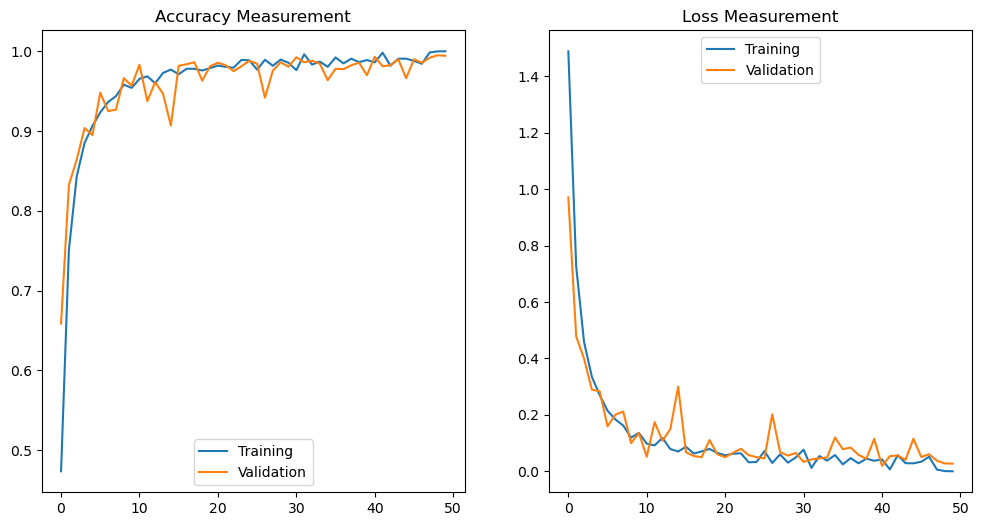

In [111]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),history.history['accuracy'],label='Training')
plt.plot(range(EPOCHS),history.history['val_accuracy'],label='Validation')
plt.legend(loc='lower center')
plt.title('Accuracy Measurement')
plt.legend(loc='lower center')
plt.subplot(1,2,2)
plt.plot(range(EPOCHS),history.history['loss'],label='Training')
plt.plot(range(EPOCHS),history.history['val_loss'],label='Validation')
plt.legend(loc='upper center')
plt.title('Loss Measurement')

In [112]:
def predict_class(model,img):
    img = tf.keras.preprocessing.image.array_to_img(img.numpy())
    img = tf.expand_dims(img,0)
    predict = model.predict(img)
    predict_name = cls_name[np.argmax(predict[0])]
    confidence = round(np.max(predict[0]),2)
    return predict_name,confidence

1/1 [==============================] - 0s 32ms/step


<Figure size 1500x2500 with 0 Axes>

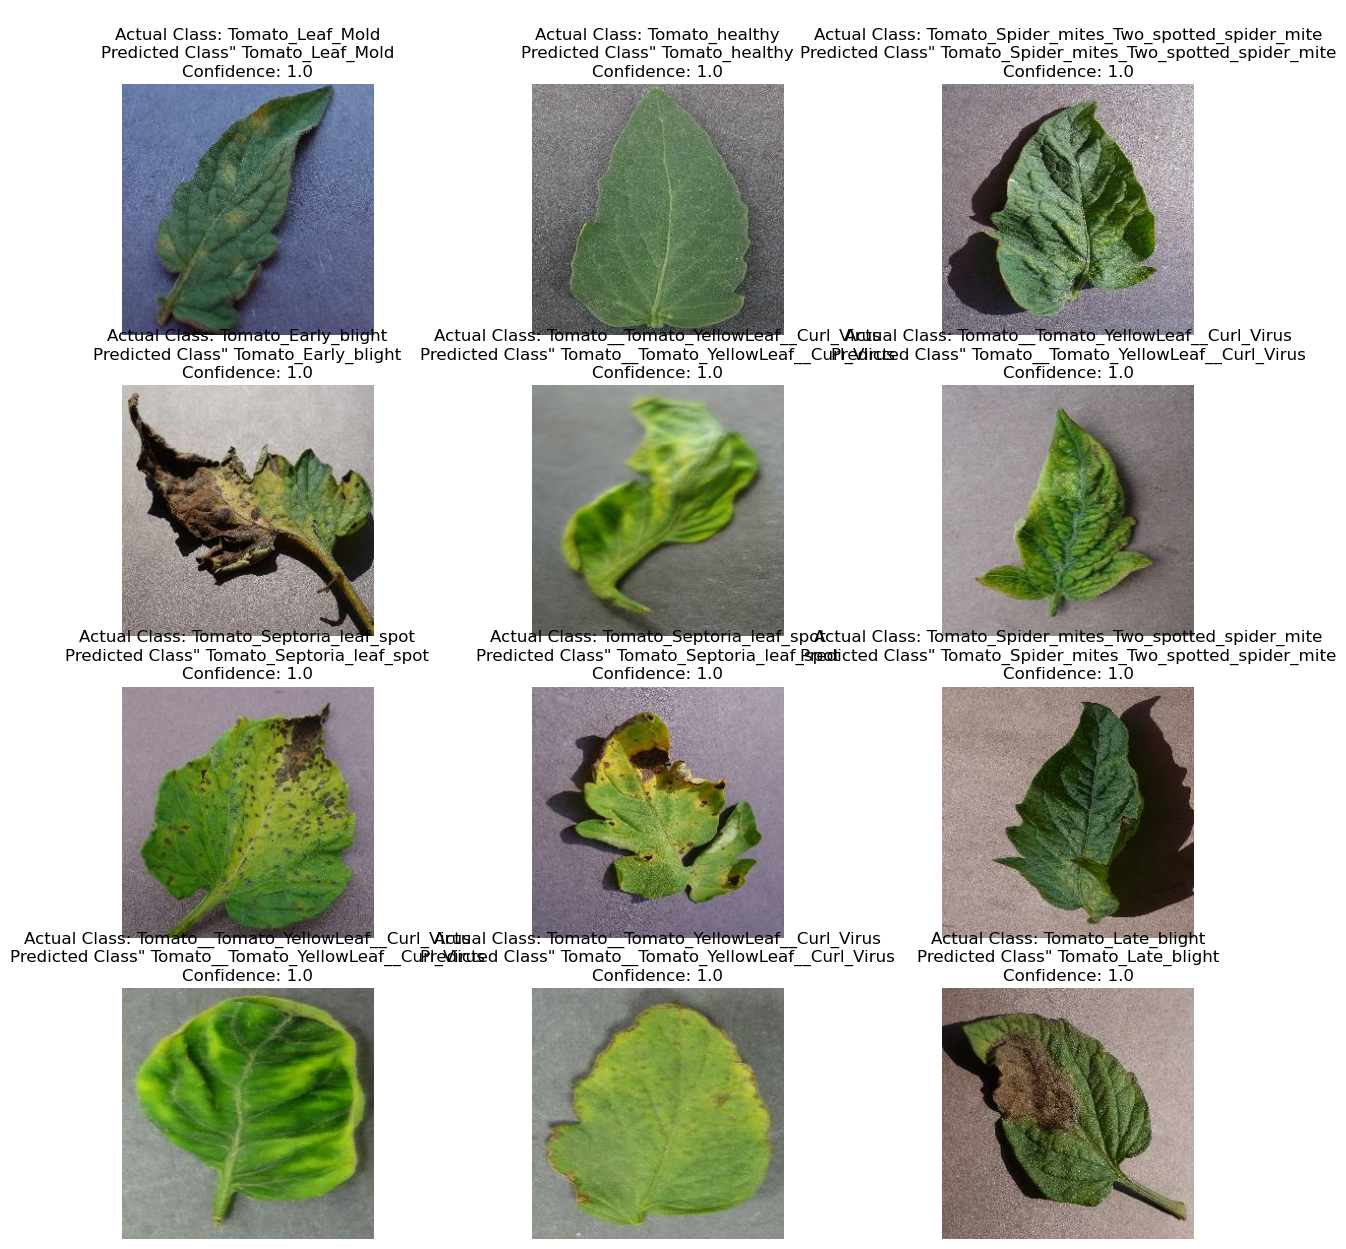

In [113]:
plt.figure(figsize=(15,25))
for img,label in test_ds.take(1):
    plt.figure(figsize=(15,15))
    for i in range(12):
        plt.subplot(4,3,i+1)
        plt.imshow(img[i].numpy().astype('uint8'))
        plt.axis('off')
        predict_name,confidence = predict_class(model,img[i])
        plt.title(f'\nActual Class: {cls_name[label[i].numpy()]}\nPredicted Class" {predict_name}\nConfidence: {confidence}')
       
    

In [114]:
model_name = '1'

In [115]:
model.save(f'..\\Models\\{model_name}')

INFO:tensorflow:Assets written to: ..\Models\1\assets


INFO:tensorflow:Assets written to: ..\Models\1\assets
